In [1]:
import pandas as pd
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, Lars, BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from scipy import stats
from scipy.stats import norm, skew, boxcox
from scipy.special import boxcox1p, inv_boxcox
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [2]:
fnc = pd.read_csv('fnc.csv')
loading = pd.read_csv('loading.csv')
reveal = pd.read_csv('reveal_ID_site2.csv')
sample = pd.read_csv('sample_submission.csv')
train_scores = pd.read_csv('train_scores.csv')

fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])
loading = loading.drop(['IC_20'], axis=1)
loading_features.remove('IC_20')

In [3]:
df = fnc.merge(loading, on="Id")
score_array = []

In [4]:
np.random.seed(0)
SEED = 0
NUM_FOLDS = 7
FNC_SCALE = 1/500

In [5]:
scaler = MinMaxScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
scaler = RobustScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

train_scores.fillna(0, inplace=True)
train_scores["is_train"] = True
df = df.merge(train_scores, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

In [6]:
df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [7]:
for col in loading_features:
    lower_quant = np.quantile( df[df[col].notnull()][col], 0.00)
    upper_quant = np.quantile( df[df[col].notnull()][col], 0.99)
    df.loc[(df[col] <= lower_quant), col]  = np.nan
    df.loc[(df[col] >= upper_quant), col]  = np.nan

In [8]:
df = df.dropna()
for col in ['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']:
    df.loc[df[col]==0.0, col] = np.nan

In [9]:
#tuning

In [15]:
target = 'domain1_var2'
features = loading_features + fnc_features 
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, df[df[target].notnull()][features], df[df[target].notnull()][target], scoring='neg_mean_squared_error', cv=NUM_FOLDS))
    return rmse

In [16]:
%%time

alphas_ridge = [ 0.1, 1, 10, 100, 1000, 1500, 2000]
cv_ridge = [rmse_cv(Ridge(alpha = al)).mean() for al in alphas_ridge]

cv_ridge = pd.Series(cv_ridge, index=alphas_ridge)
print(cv_ridge)

0.1       11.296282
1.0       11.282859
10.0      11.281476
100.0     11.275969
1000.0    11.264114
1500.0    11.263863
2000.0    11.264317
dtype: float64
CPU times: user 44.2 s, sys: 12.2 s, total: 56.4 s
Wall time: 14.5 s


Text(0, 0.5, 'rmse')

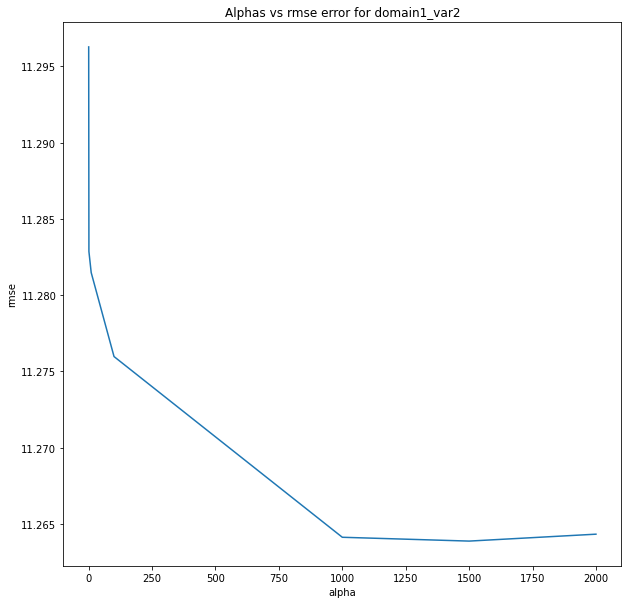

In [17]:
plt.figure(figsize=(10,10))
cv_ridge.plot(title='Alphas vs rmse error for {}'.format(target))
plt.xlabel('alpha')
plt.ylabel('rmse')

In [13]:
#tuning done

In [10]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,is_train
0,10001,0.000945,-0.000262,-0.000965,-0.001387,0.000215,0.001237,0.001981,-0.000118,-0.000913,...,-0.171083,-1.078176,-0.776453,0.232126,57.436077,30.571975,62.553736,53.325130,51.427998,True
1,10002,-0.000809,-0.001810,-0.003311,-0.000653,-0.000085,0.000327,0.000038,0.000301,0.000269,...,-0.174312,-0.260505,-0.159178,-0.301074,59.580851,50.969456,67.470628,60.651856,58.311361,True
3,10004,-0.000962,0.000476,-0.000406,-0.001370,0.002247,0.001711,0.001306,0.000986,0.001270,...,0.616209,-0.084408,-0.354851,-0.253910,71.413018,53.152498,58.012103,52.418389,62.536641,True
4,10005,0.000325,0.000419,-0.001196,0.000239,-0.001076,-0.000483,-0.001026,0.001065,0.000052,...,-0.224218,-0.656013,-1.706584,-0.542493,66.532630,NaN,NaN,52.108977,69.993075,True
6,10007,-0.001846,0.000424,0.000453,-0.001411,0.000813,-0.000762,-0.000675,-0.000242,0.000446,...,-0.742734,0.744925,0.059050,-0.334249,38.617381,49.197021,65.674285,40.151376,34.096421,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,21746,-0.001715,-0.000982,-0.001203,-0.000471,0.000718,0.001871,0.001547,-0.000342,-0.000036,...,-0.060019,0.362313,1.195855,-0.994754,14.257265,21.358872,61.165998,51.778483,54.640179,True
11746,21747,-0.000079,0.000074,0.000781,0.001393,0.000601,-0.000881,-0.001782,-0.000496,-0.001957,...,0.067062,-0.969828,0.955988,0.190157,55.456978,68.169675,29.907995,55.349257,54.019517,True
11749,21750,-0.000192,-0.003407,-0.002961,-0.000419,-0.000040,-0.001048,-0.001081,-0.000855,-0.000076,...,1.115187,-0.706855,0.441959,0.292081,48.948756,55.114811,60.878271,38.617246,50.679885,True
11751,21752,-0.001080,0.002042,0.000844,-0.000611,0.000800,0.000774,0.001018,0.000272,0.001258,...,-0.440176,-0.014068,-0.870347,0.711766,66.532630,59.844808,72.303110,55.458281,46.870235,True


In [11]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
features = loading_features + fnc_features

for target, c, w, al in [ ('age', 6, 0.3, 0.004), ('domain1_var1', 0, 0.175, 0.1), ('domain2_var1', 0, 0.175, 0.08)]:    

    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha = al)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    score_array.append(score)
    print(target, np.round(score, 5), np.round(score, 4))
    

age 0.14162 0.1416
domain1_var1 0.14951 0.1495
domain2_var1 0.17994 0.1799


In [12]:
#other way around

In [13]:
df = fnc.merge(loading, on="Id")
scaler = MinMaxScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
scaler = RobustScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

train_scores = pd.read_csv('train_scores.csv')
train_scores.fillna(0, inplace=True)
train_scores["is_train"] = True
df = df.merge(train_scores, on="Id", how="left")

df[fnc_features] *= FNC_SCALE

In [14]:
for col in loading_features:
    lower_quant = np.quantile( df[df[col].notnull()][col], 0.01)
    upper_quant = np.quantile( df[df[col].notnull()][col], 1.00)
    df.loc[(df[col] <= lower_quant), col]  = np.nan
    df.loc[(df[col] >= upper_quant), col]  = np.nan

In [15]:
df = df.dropna()
for col in ['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']:
    df.loc[df[col]==0.0, col] = np.nan

In [16]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,is_train
0,10001,0.000945,-0.000262,-0.000965,-0.001387,0.000215,0.001237,0.001981,-0.000118,-0.000913,...,-0.171083,-1.078176,-0.776453,0.232126,57.436077,30.571975,62.553736,53.325130,51.427998,True
1,10002,-0.000809,-0.001810,-0.003311,-0.000653,-0.000085,0.000327,0.000038,0.000301,0.000269,...,-0.174312,-0.260505,-0.159178,-0.301074,59.580851,50.969456,67.470628,60.651856,58.311361,True
3,10004,-0.000962,0.000476,-0.000406,-0.001370,0.002247,0.001711,0.001306,0.000986,0.001270,...,0.616209,-0.084408,-0.354851,-0.253910,71.413018,53.152498,58.012103,52.418389,62.536641,True
6,10007,-0.001846,0.000424,0.000453,-0.001411,0.000813,-0.000762,-0.000675,-0.000242,0.000446,...,-0.742734,0.744925,0.059050,-0.334249,38.617381,49.197021,65.674285,40.151376,34.096421,True
7,10008,-0.000792,0.000152,-0.000428,-0.000518,-0.000322,0.000186,0.000666,-0.000225,0.000162,...,-0.754635,0.083421,0.534935,-1.018136,35.326582,15.769168,65.782269,44.643805,50.448485,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,21742,-0.001104,-0.001224,-0.000543,-0.000944,-0.001538,-0.000844,-0.002127,-0.001638,-0.001942,...,-0.264963,0.665725,0.426004,-0.581064,59.580851,58.912771,61.462487,36.887759,48.465598,True
11743,21744,0.001360,-0.000252,-0.001665,0.000517,0.001276,0.001055,0.000472,-0.001015,-0.000731,...,1.130251,0.319738,1.869796,0.213740,28.442742,57.094722,63.339246,35.432860,57.366755,True
11745,21746,-0.001715,-0.000982,-0.001203,-0.000471,0.000718,0.001871,0.001547,-0.000342,-0.000036,...,-0.060019,0.362313,1.195855,-0.994754,14.257265,21.358872,61.165998,51.778483,54.640179,True
11749,21750,-0.000192,-0.003407,-0.002961,-0.000419,-0.000040,-0.001048,-0.001081,-0.000855,-0.000076,...,1.115187,-0.706855,0.441959,0.292081,48.948756,55.114811,60.878271,38.617246,50.679885,True


In [17]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
features = loading_features + fnc_features

for target, c, w, al in [ ('domain1_var2', 0, 0.175, 1500), ('domain2_var2', 0, 0.175, 0.05)]:    

    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha = al)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    score_array.append(score)
    print(target, np.round(score, 5), np.round(score, 4))

domain1_var2 0.1499 0.1499
domain2_var2 0.17568 0.1757


In [18]:
#final_score
score_array[0] * 0.3 + score_array[1] * 0.175 + score_array[2] * 0.175 + score_array[3] * 0.175 + score_array[4] * 0.175 

0.15711610830700604

In [19]:
#submission

In [20]:
sub_df = pd.melt(test_df[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

,Id,Predicted
0,10003_age,60.296291
5877,10003_domain1_var1,47.876650
11754,10003_domain1_var2,59.470484
17631,10003_domain2_var1,49.337004
23508,10003_domain2_var2,55.970986
1,10006_age,63.218229
5878,10006_domain1_var1,54.251134
11755,10006_domain1_var2,58.474734
17632,10006_domain2_var1,50.009841
23509,10006_domain2_var2,52.138269


In [21]:
sub_df.to_csv('subs/checking_effect_of_outlier_removal_loading_based_1percentile_target_based.csv', index=False)

In [22]:
#lb : 0.1609 maybe more data implies better data over here